The Green-Ampt model is a widely used method for predicting infiltration rate into the soil. The model assumes that the soil is initially dry and that water redistributes into the soil in the form of piston flow. The infiltration rate decreases over time as a result of a weaker hydraulic gradient caused by the increasing length of the wetting front. The Green-Ampt model provides a simple yet effective way to estimate infiltration rate, the approximate time of ponding, and infiltration-excess runoff, making it a valuable tool for hydrologists and soil scientists. The code presented below is based on the following tutorial prepared for the National Weather Service COMET outreach program (Tarboton, 2003): https://hydrology.usu.edu/rrp/ch5resources/GA.htm

The three key equations to solve the Green-Ampt model numerically the following:

#### 1) Infiltration capacity

$$ f_c = K_{sat} \Bigg(1 + \frac{P}{F} \Bigg)$$

$f_c$ is the infiltration capacity<br>
$ K_{sat}$ is the saturated hydraulic connductivity<br>
$F$ is the cumulative infiltration


#### 2) Cumulative infiltration at time of ponding

$$ F_p = \frac{K_{sat}P}{w-K_{sat}} ~~~ , w>K_{sat}$$

$F_p$ is the cumulative infiltration when ponding occurs<br>
$w$ is the rainfall rate

#### 3) Cumulative infiltration under ponded conditions

$$ 0 = t - t_p - \frac{F-F_p}{K_{sat}} + \frac{P}{K_{sat}} ln \Bigg(\frac{F_p+P}{F+P}  \Bigg)$$

where $P$ is the moisture difference suction parameter. We solve this function implicitly for F



In the code below, we are also using the following variables:

$dt^{'}$ is the partial time interval required for ponding to occur

$t_p$ is time during which ponding occurs

$f_t$ is infiltration during time step $t$

$r_t$ is runoff during time step $t$

The model works on the premise that, if rainfall rate is lower than the infiltration capacity ($f_c$), then all the rainfall infiltrates the soil. However, if the rainfall rate is greater than the infiltration capacity of the soil, then ponding occurs. 

Much of the coding needed to solve the Green-Ampt model deals with what happens within the time interval ($dt$). In other words, even in the case where there is no ponding at the beginning of the time interval, it's still possible for ponding to occur within the time interval. To resolve this, tentative values of infiltration capacity ($f_c^{'}$) and cumulative infiltration ($F^{'}$) are computed within the interval assuming that all the water infiltrates. If the rainfall rate is greater than ($f_c^{'}$), then ponding occurs at some point during the time step. Note that if ponding does not occur during the entire interval, computations are simpler and we move onto the next step. Additional calculations using a solver are required when we find that ponding occurs at some point during the time interval.

Something important to remember is that rainfall rate can increase or decrease over time, but the infiltration capacity of the soil decreases as more water infiltrates the soil. 

In [151]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve


In [152]:
# Data (same as in the tutorial)

# 15-minute time intervals expressed in hours
time = np.array([0, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00])

# Rainfall during time interval expressed in cm
rainfall = np.array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.4, 0.6, 0.6])

# Compute rainfall intensity in cm/hr
intensity = rainfall/dt


In [153]:
# Parameters

# Time step at which rainfall is measred
dt = 15/60 # hours

# Saturated hydraulic conductivity (measured or from database)
Ks = 1.09 # cm/hour for sandy loam soil

# Soil saturation
theta_sat = 0.453 # volumetric water at saturation

# Matric potential at the wetting front
Hf = 11.01 

# Air-entry suction
Ha = 21.8 # cm

# Parameter to represent pore-size distribution
b = 4.9 

# Initial soil moisture content
# Initial volumetric water of the profile (remains constant below the wetting front)
theta_ini = 0.259

# Matric potential at field capacity
#H_ini = 10 * 10.2 # Set first value in kPa (10.2 converts kPa to cm)
#theta_ini = theta_sat*(H_ini/Ha)**(-1/b)

# Moisture difference suction parameter
P = Hf * (theta_sat - theta_ini)


In [155]:
# Get number of elements
N = time.shape[0]

# Pre-allocate variables
F = np.full(N, np.nan)
fc = np.full(N, np.nan)
Fp = np.full(N, np.nan)
F_prime = np.full(N, np.nan)
fc_prime = np.full(N, np.nan)
dt_prime = np.full(N, np.nan)
ts = np.full(N, np.nan)
Ft_dt = np.full(N, np.nan)
ft = np.full(N, np.nan)
r = np.full(N, np.nan)


In [165]:
# Iterate over each time step
for t in range(N):
    
    # Initial cumulative infiltration and infiltration capacity at t=0
    if t == 0:
        F[t] = 0
        fc[t] = np.inf # because we are dividing by F[t]=zero
    
    else:
        F[t] = Ft_dt[t-1]
        fc[t] = Ks * (1 + P/F[t])

    # If no ponding occurs at the beginning of the time step
    if fc[t] > intensity[t]:
        F_prime[t] = F[t] + rainfall[t]
        fc_prime[t] = Ks*(1 + P/F_prime[t])

        # Check for ponding conditions within the current time step (partial ponding)
        if fc_prime[t] < intensity[t]:
            Fp[t] = Ks * P / (intensity[t] - Ks)
            dt_prime[t] = (Fp[t] - F[t])/intensity[t]
            ts[t] = time[t] + dt_prime[t]
            gF = lambda x: (time[t]+dt - ts[t]) - (x - Fp[t])/Ks - P/Ks * np.log((Fp[t]+P)/(x+P))
            Ft_dt[t] = fsolve(gF, x0=Fp[t])
        
        else:
            Ft_dt[t] = F_prime[t]
    
    # If ponding occurs at the beginning of the time step
    else:
        Fp[t] = F[t]
        dt_prime[t] = 0
        ts[t] = time[t]
        gF = lambda x: (time[t]+dt - ts[t]) - (x - Fp[t])/Ks - P/Ks * np.log((Fp[t]+P)/(x+P))
        Ft_dt[t] = fsolve(gF, x0=Fp[t])
            
    # Compute infiltration and runoff during time step
    ft[t] = Ft_dt[t] - F[t]
    r[t] = rainfall[t] - ft[t]
    

# Create output table
df = pd.DataFrame({"time":time, "rainfall":rainfall, "intensity":intensity, 
                   "Ft":F, 'fc':fc, "F'":F_prime, "fc'":fc_prime, 'Fp':Fp,
                   "dt'":dt_prime, "ts":ts, "Ft+dt":Ft_dt,
                   "ft":ft, "rt":r}).round(5)

df.head(9)

,time,rainfall,intensity,Ft,fc,F',fc',Fp,dt',ts,Ft+dt,ft,rt
0,0.00,0.3,1.2,0.00000,inf,0.3000,8.85058,NaN,NaN,NaN,0.30000,0.30000,0.00000
1,0.25,0.4,1.6,0.30000,8.85058,0.7000,4.41596,NaN,NaN,NaN,0.70000,0.40000,0.00000
2,0.50,0.5,2.0,0.70000,4.41596,1.2000,3.03015,NaN,NaN,NaN,1.20000,0.50000,0.00000
3,0.75,0.6,2.4,1.20000,3.03015,1.8000,2.38343,1.77723,0.24051,0.99051,1.79992,0.59992,0.00008
4,1.00,0.7,2.8,1.79992,2.38349,NaN,NaN,1.79992,0.00000,1.00000,2.35351,0.55359,0.14641
5,1.25,0.8,3.2,2.35351,2.07923,NaN,NaN,2.35351,0.00000,1.25000,2.85010,0.49658,0.30342
6,1.50,0.4,1.6,2.85010,1.90688,3.2501,1.80634,NaN,NaN,NaN,3.25010,0.40000,0.00000
7,1.75,0.6,2.4,3.25010,1.80634,NaN,NaN,3.25010,0.00000,1.75000,3.69046,0.44036,0.15964
8,2.00,0.6,2.4,3.69046,1.72086,NaN,NaN,3.69046,0.00000,2.00000,4.11224,0.42178,0.17822


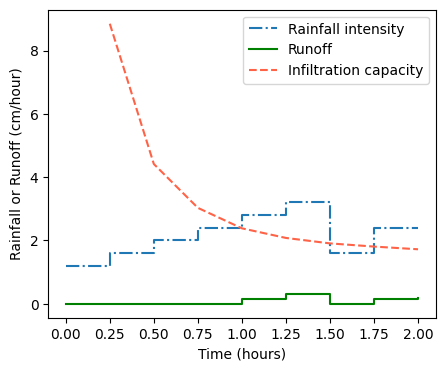

In [166]:
# Create a figure
plt.figure(figsize=(5,4))
plt.step(time, intensity, where='post', linestyle='-.', label='Rainfall intensity')
plt.step(time, r, where='post', linestyle='-', color='green', label='Runoff')
plt.plot(time, fc, linestyle='--', color='tomato', label='Infiltration capacity')
plt.xlabel('Time (hours)')
plt.ylabel('Rainfall or Runoff (cm/hour)')
plt.legend(loc='upper right')
plt.show()


In [169]:
# Compute and print totals
total_rainfall= df['rainfall'].sum()
total_runoff = df['rt'].sum()

print('Total rainfall', round(total_rainfall,1), 'cm')
print('Total runoff', round(total_runoff,1), 'cm')

Total rainfall 4.9 cm
Total runoff 0.8 cm


## References

Tarboton, D. G. (2003). Rainfall-runoff processes. Utah State University, 1(2). https://hydrology.usu.edu/rrp/Workbook.htm